# Analysis of VAV1 Simulations

Author: Simone Orioli  
Email: simone.orioli@nbi.ku.dk

Notebook with all the implemented scripts and the analyses performed for the manusctipt "Transient exposure of a buried  phosphorylation site in an autoinhibited protein". Data are available on Zenodo (see Github README).   
*NOTE*: The notebook is meant to be run from beginning to end. Running cells in an order different from the specified one might result in undesired behaviours. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import mdtraj as md
from itertools import combinations, product
from matplotlib import gridspec
import matplotlib.cm as cm
import glob
import pandas as pd
from scipy.stats import gaussian_kde
#import BLOCKING.MonoFES.fblock as fblock
#import BLOCKING.MonoCV.block as block
import pyemma
from pyemma.util.contexts import settings

In [2]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['axes.titlesize']  = 18
mpl.rcParams['legend.fontsize'] = 16

## Helper Functions

In [3]:
def best_hummer_q(traj, native):

    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 2
    NATIVE_CUTOFF = 0.45  # nanometers

    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])

    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]

    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)

    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

In [4]:
def selection_string(rr):
    s = ''
    for r in rr:
        s += f'residue {r} and (sidechain and not type H or name CA)'
        if r != rr[-1]:
            s += ' or '  
    return s

In [5]:
def cvs_for_plumed(native, discardj, helix, helix_c, group1, group2, fprotein, filename, outname):
    k = 1
    cutoff = 0.6 #nm
    
    #compute distances and pairs
    top    = native.topology 
    natoms = native.n_atoms
    heavy  = top.select_atom_indices('heavy')
    
    heavy_pairs = np.array([(i,j) for (i,j) in combinations(heavy, 2)
                            if abs(top.atom(i).residue.index - \
                                   top.atom(j).residue.index) > 3 
                                   and (top.atom(i).residue.index in helix_c)
                                   and j not in discardj])

    heavy_pairs_distances = md.compute_distances(native, heavy_pairs)[0]
    pairs = heavy_pairs[heavy_pairs_distances < cutoff]
    distances = heavy_pairs_distances[heavy_pairs_distances < cutoff]
    
    ind_psi, psi = md.compute_psi(native, periodic=False)
    ind_phi, phi = md.compute_phi(native, periodic=False)
    
    g1 = []
    g2 = []
    for i in group1:
        g1.append(i)
    
    for i in group2:
        g2.append(i)
        
    pairs_groups = np.array(list(product(g1, g2)))
    dist_groups = md.compute_distances(native, pairs_groups, periodic=False, opt=False)[0]
    
    weight = 1./len(distances)
    weight_groups = 1./len(dist_groups)
    
    with open(filename, 'w') as f:
        f.write(f'MOLINFO STRUCTURE={fprotein}\n')
        f.write(f'prot: GROUP ATOMS=1-{natoms}\n')
        f.write('WHOLEMOLECULES ENTITY0=prot\n\n')
        
        f.write('CONTACTMAP ...\n')
        c = 1
        
        for p in pairs:
            atom = f'ATOMS{c}={p[0]+1},{p[1]+1} SWITCH{c}={{Q R_0=0.01 BETA=50.0 LAMBDA=2. REF={distances[c-1]}}} WEIGHT{c}={weight}\n'
            f.write(atom)
            c += 1

        f.write('LABEL=q\n')
        f.write('SUM\n')
        f.write('NOPBC\n')
        f.write('... CONTACTMAP\n')
        
        f.write('\nCONTACTMAP ...\n')
        c = 1
        
        for p in pairs_groups:
            atom = f'ATOMS{c}={p[0]+1},{p[1]+1} SWITCH{c}={{Q R_0=0.01 BETA=50.0 LAMBDA=2. REF={dist_groups[c-1]}}} WEIGHT{c}={weight_groups}\n'
            f.write(atom)
            c += 1

        f.write('LABEL=qtyr\n')
        f.write('SUM\n')
        f.write('NOPBC\n')
        f.write('... CONTACTMAP\n')

        f.write("\nALPHABETA ...\n")
        
        for i in range(helix[0]-1, helix[-1]):

            ndx1 = top.select( f'resid {i} and name C or resid {i+1} and name N CA C')
            ndx2 = top.select( f'resid {i+1} and name N CA C or resid {i+2} and name N')

            f.write(f"ATOMS{k}=")
            for j in ndx1:
                if j != ndx1[-1]:
                    f.write(f"{j+1},")
                else:
                    f.write( str(j+1) )
            f.write(f" REFERENCE{k}={phi[0][i]}\n")

            f.write(f"ATOMS{k+1}=")
            for j in ndx2:
                if j != ndx2[-1]:
                    f.write(f"{j+1},")
                else:
                    f.write(str(j+1))
            f.write(f" REFERENCE{k+1}={psi[0][i+1]}\n")

            k += 2
            
        f.write("LABEL=ab\n")
        f.write("... ALPHABETA\n")
        
        f.write(f'\nPRINT ARG=q,ab,qtyr FILE={outname}')

In [6]:
def quick_load( file ):
    dataset = pd.read_csv(file, delimiter=r"\s+", header = None, comment='#')
    return dataset.values

In [7]:
def prange(ll):
    """
    Returns a list with the elements of the input list split in tuple pairs
    Ex. ll = [1,2,3,4]
    Returns [(1,2),(3,4)]
    """
    try:
        ll = list(ll)
    except TypeError:
        print("ll has to be iterable")
        
    return list(zip(ll[0::2], ll[1::2]))

In [8]:
def get_pairs(indexes, struct, helix, cutoff=0.6):
    top = struct.topology
    cutoff = 0.6
    all_pairs = np.array([(i,j) for (i,j) in combinations(indexes, 2)
                                 if (top.atom(i).residue.index in helix) \
                                 and (top.atom(j).residue.index not in helix)]) 
    pairs_distances = md.compute_distances(struct, all_pairs)[0]
    pairs = all_pairs[pairs_distances < cutoff]
    
    return pairs

In [9]:
def plot_rectangle(conf, color, lw):
    plt.hlines(conf[2], conf[0], conf[1], color=color, lw=lw)
    plt.hlines(conf[3], conf[0], conf[1], color=color, lw=lw)
    plt.vlines(conf[0], conf[2], conf[3], color=color, lw=lw)
    plt.vlines(conf[1], conf[2], conf[3], color=color, lw=lw)

In [10]:
def integrate_prob(h, conf):
    norm = np.sum(h)
    s = np.sum(h[conf[0]:conf[1],conf[2]:conf[3]])
    return s/norm

In [11]:
def block_deltaG(data, config1, config2, i, j, k):
    N, n_blocks, block_sizes = block.blocker(data[:,i], multi=2) 
    h, _, _ = np.histogram2d(data[:,i], data[:,j], bins=100, weights=data[:,k])
    u1 = integrate_prob(h, config1)
    u2 = integrate_prob(h, config2)
    
    err = np.zeros(len(block_sizes))
    err_err = np.zeros(len(block_sizes))
    for b in range(len(block_sizes)):
        Nb = n_blocks[b]
        his1 = 0
        his2 = 0
        for n in range(1,Nb+1):
            end = int(block_sizes[b] * n)
            start = int(end - block_sizes[b])
            htmp, _, _ = np.histogram2d(data[start:end,i], data[start:end,j], bins=80, weights=data[start:end,k])
            his1 += (integrate_prob(htmp, config1)-u1)**2
            his2 += (integrate_prob(htmp, config2)-u2)**2
            
        e1 = np.sqrt(his1/(Nb*(Nb-1)))
        e1 = e1/u1
        e2 = np.sqrt(his2/(Nb*(Nb-1)))
        e2 = e2/u2
        e = np.sqrt(e1**2 + e2**2)
        err[b] += e.mean()
        err_err[b] += err[b] / np.sqrt( 2*(Nb-1) )
    return np.flip(np.array([block_sizes, err, err_err]).T, axis=0)

In [12]:
def block_population(data, config, i, j, k):
    N, n_blocks, block_sizes = block.blocker(data[:,i], multi=2) 
    h, _, _ = np.histogram2d(data[:,i], data[:,j], bins=100, weights=data[:,k])
    u = integrate_prob(h, config)
    
    err = np.zeros(len(block_sizes))
    err_err = np.zeros(len(block_sizes))
    for b in range(len(block_sizes)):
        Nb = n_blocks[b]
        his = 0
        for n in range(1,Nb+1):
            end = int(block_sizes[b] * n)
            start = int(end - block_sizes[b])
            htmp, _, _ = np.histogram2d(data[start:end,i], data[start:end,j], bins=80, weights=data[start:end,k])
            his += (integrate_prob(htmp, config)-u)**2
            
        e = np.sqrt(his/(Nb*(Nb-1)))
        err[b] += e.mean()
        err_err[b] += err[b] / np.sqrt( 2*(Nb-1) )
    return np.flip(np.array([block_sizes, err, err_err]).T, axis=0)

In [13]:
def score_cv(data, dim, lag, number_of_splits = 10, validation_fraction = 0.5):
    
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

In [14]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

## Exploratory Molecular Dynamics

### Load Data

Reference directories and filenames  
Simulation categories: crystal structure with `a99sb-disp`, crystal structure with `C36m`, NMR structure with `a99sb-disp` and NMR structure with `C36m`

In [60]:
sim = 'trajectories/md/'
tp = 'topologies/'
pics = 'pics/analysis/'
plumed = 'plumed/md/'
colvars = 'colvars/md/' 
filenames = ['nmr_disp', 'cry_disp', 'nmr_c36m', 'cry_c36m' ] 
max_frame = 2000 #corresponding to 1us
stride = 10

Load reference topologies and trajectories

In [14]:
tops = {}
trjs = {}
for f in filenames:
    tops[f] = md.load(tp + f + '.pdb')
    trjs[f] = md.load(sim + f + '.xtc', top=tops[f], stride=stride)[:max_frame]

### RMSD and Q

Compute obervables

In [15]:
q = {}
rmsd = {}
for k in tops.keys():
    q[k] = best_hummer_q(trjs[k], tops[k])
    rmsd[k] = md.rmsd(trjs[k], tops[k]) 
x = np.arange(0, 1, 1./max_frame) #for plotting

/Users/simone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


### Collective Variables

Write Plumed files for CV calculations

In [16]:
helix_c = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
helix = [1, 2, 3, 4, 5, 6, 7, 8]
discardj = []
r1 = [6]
r2 = [37, 41, 160, 163, 164]
shift = 168

for k in tops.keys():
    natoms = tops[k].n_atoms
    plumedf = os.path.abspath(plumed + k + '.dat') 
    cvfile = os.path.abspath(colvars + 'CV12_' + k)
    fprotein = os.path.abspath(tp + k + '.pdb') 
    top = tops[k].topology
    
    if 'cry' in k:
        group1 = top.select(selection_string(r1))
        group2 = top.select(selection_string(r2))
    else:
        group1 = top.select(selection_string([r + shift for r in r1]))
        group2 = top.select(selection_string([r + shift for r in r2]))
    
    pairs = cvs_for_plumed(tops[k], discardj, helix, helix_c, group1, group2, fprotein, plumedf, cvfile)

Use Plumed to compute the values of CVs for the different simulations

In [17]:
#for k in tops.keys():
#    ! plumed driver --mf_xtc {os.path.abspath( sim + k + '.xtc' )} --plumed {os.path.abspath( plumed + k + '.dat' )} 

Load data from files

In [18]:
cvs = {}
for k in tops.keys():
    cvs[k] = np.genfromtxt(colvars + 'CV12_' + k)[::stride][:max_frame]

### Y174-R332 hydrogen bond

In [19]:
hbond = {}
for k in tops.keys():
    tmp = np.genfromtxt(colvars + k + '_hbond.dat')[::stride][:max_frame]
    hbond[k] = np.array([i[0] for i in tmp if i[1] == 1])

### Paper figures

**Fig**. S1

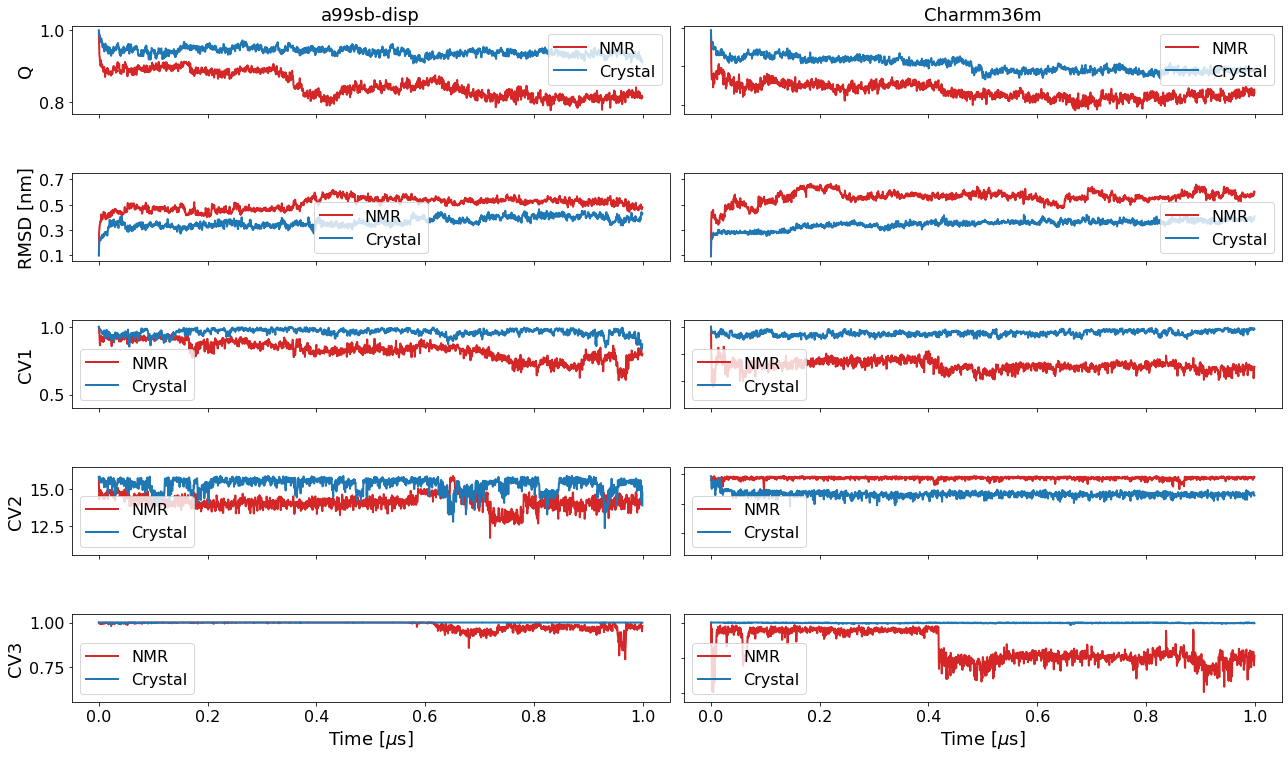

In [20]:
p = 0 #plot number
plt.figure(figsize=(18,12))
for i,j in zip( list(tops.keys())[0::2], list(tops.keys())[1::2]):
    plt.subplot(len(cvs)+2, 2, p+1)
    
    if p == 0:
        plt.title('a99sb-disp')
        plt.ylabel('Q')
    else:
        plt.title('Charmm36m')
        plt.yticks([0.8,0.9,1.], "")
        
    plt.plot(x, q[i], label='NMR', c='tab:red', linewidth=2)
    plt.plot(x, q[j], label='Crystal', c='tab:blue', linewidth=2)
    plt.legend()
    plt.xticks([0.,0.2,0.4,0.6,0.8,1.], "")
    p += 1

p = 0
for i,j in zip( list(tops.keys())[0::2], list(tops.keys())[1::2]):
    plt.subplot(len(cvs)+2, 2, p+3)
    plt.plot( x, rmsd[i], label = 'NMR',     c = 'tab:red', linewidth = 2 )
    plt.plot( x, rmsd[j], label = 'Crystal', c = 'tab:blue',  linewidth = 2 )
    plt.legend()
    plt.xticks([0.,0.2,0.4,0.6,0.8,1.], "")
    plt.ylim( (0.05,0.75) )
    plt.yticks([0.1, 0.3, 0.5, 0.7])
    
    if p == 0:
        plt.ylabel( 'RMSD [nm]' )
    else:
        plt.yticks([0.1, 0.3, 0.5, 0.7], "")
    p += 1
    
    plt.xticks([0.,0.2,0.4,0.6,0.8,1.], "")

ylims = [(0.4, 1.05), (10.5, 16.5), (0.55, 1.05)]
ylabels = [[0.6, 0.8, 1], [12., 14., 16.], [0.6, 0.8, 1]]
p = 0
for c in range(1,4):
    for i,j in zip(list(tops.keys())[0::2], list(tops.keys())[1::2]):
        plt.subplot(len(cvs)+2, 2, p+5)

        plt.plot(x, cvs[i][:,c], label='NMR', c='tab:red', linewidth=2)
        plt.plot(x, cvs[j][:,c], label='Crystal', c='tab:blue', linewidth=2)
        plt.ylim(ylims[c-1])
        plt.legend()
        
        if p%2 == 0:
            plt.ylabel(f'CV{c}')
        else:
            plt.yticks(ylabels[c-1], "")
            
        if p == len(cvs) or p == len(cvs) +1:
            plt.xlabel(r'Time [$\mu$s]')
        else:
            plt.xticks([0.,0.2,0.4,0.6,0.8,1.], "")  
        p += 1
plt.tight_layout()
#plt.savefig(pics + 'figS1.pdf', format = 'pdf')

**Fig**. S2

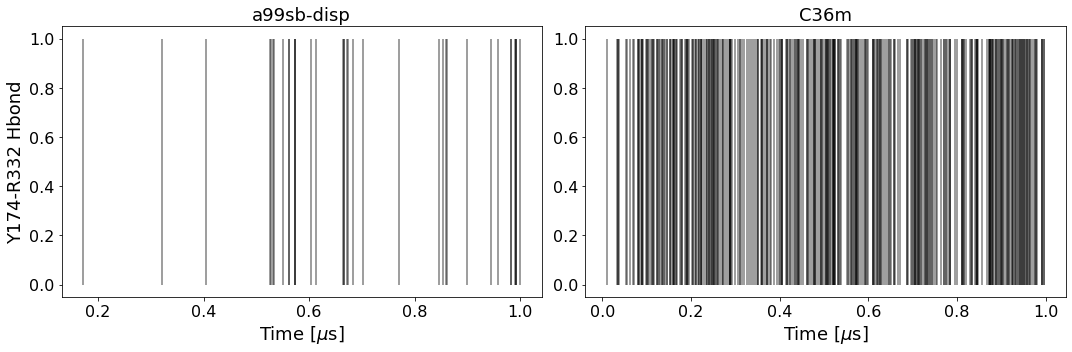

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('a99sb-disp')
for i in hbond['cry_disp']:
    plt.vlines(i/(max_frame*stride), 0, 1, alpha=0.5)
plt.ylabel('Y174-R332 Hbond')
plt.xlabel(r'Time [$\mu$s]')

plt.subplot(1,2,2)
plt.title('C36m')
for i in hbond['cry_c36m']:
    plt.vlines(i/(max_frame*stride), 0, 1, alpha=0.5)
plt.xlabel(r'Time [$\mu$s]')

plt.tight_layout()
#plt.savefig(pics + 'figS2.pdf')

**Fig**. 1C

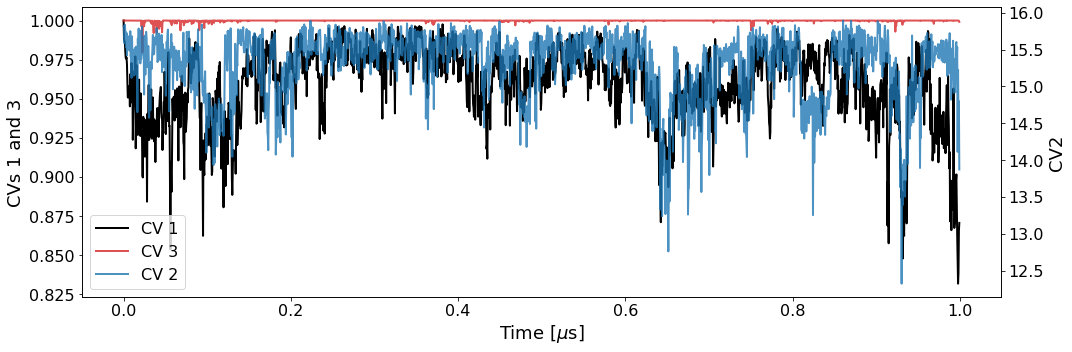

In [22]:
fig, ax1 = plt.subplots(figsize=(15,5))
l1 = ax1.plot(x, cvs['cry_disp'][:,1], label='CV 1', c='k', linewidth=2)
l2 = ax1.plot(x, cvs['cry_disp'][:,3], label='CV 3', c='tab:red', linewidth=2, alpha=0.8)

ax2 = ax1.twinx()
l3 = ax2.plot(x, cvs['cry_disp'][:,2], label='CV 2', c='tab:blue', linewidth=2, alpha=0.8)
ax1.set_xlabel(r'Time [$\mu$s]')
ax1.set_ylabel('CVs 1 and 3')
ax2.set_ylabel('CV2')

#merge labels
ls = l1 + l2 + l3
labs = [l.get_label() for l in ls]
ax1.legend(ls, labs, loc=3)

plt.tight_layout()
#plt.savefig(pics + 'fig1C.pdf')

## WTMetaD

Reference directories for WTMetaD

In [23]:
sim = 'trajectories/wtmetad/'
tp = 'topologies/'
pics = 'pics/analysis/'
plumed = 'plumed/wtmetad/'
colvars = 'colvars/wtmetad/'
kt = 2.494339

### Hills

Load hills file 

In [24]:
hills = quick_load(colvars + 'HILLS')

### Free Energy

Run `sum_hills` to get the free energy along CV1 and CV2

In [25]:
# ! plumed sum_hills --mintozero --hills {colvars + 'HILLS'} --outfile {colvars}/fes_cv1_cv2.dat

### Y174 contact map

In [26]:
helix_c = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
helix = [1, 2, 3, 4, 5, 6, 7, 8]
discardj = []
r1 = [6]
r2 = [37, 41, 160, 163, 164]
lbl = 'cry_disp'
plumedf = os.path.abspath(plumed + 'wtmetad_cv3.dat') 
cvfile = os.path.abspath(colvars + 'CV3')
fprotein = os.path.abspath(tp + lbl + '.pdb') 
top = tops[lbl].topology
group1 = top.select(selection_string(r1))
group2 = top.select(selection_string(r2))
pairs = cvs_for_plumed(tops[lbl], discardj, helix, helix_c, group1, group2, fprotein, plumedf, cvfile)

In [27]:
# ! plumed driver --mf_xtc { sim + 'wtmetad.xtc'} --plumed { plumedf }

In [28]:
cv3 = quick_load(colvars + 'CV3')

### Paper figures

**Fig**. S3

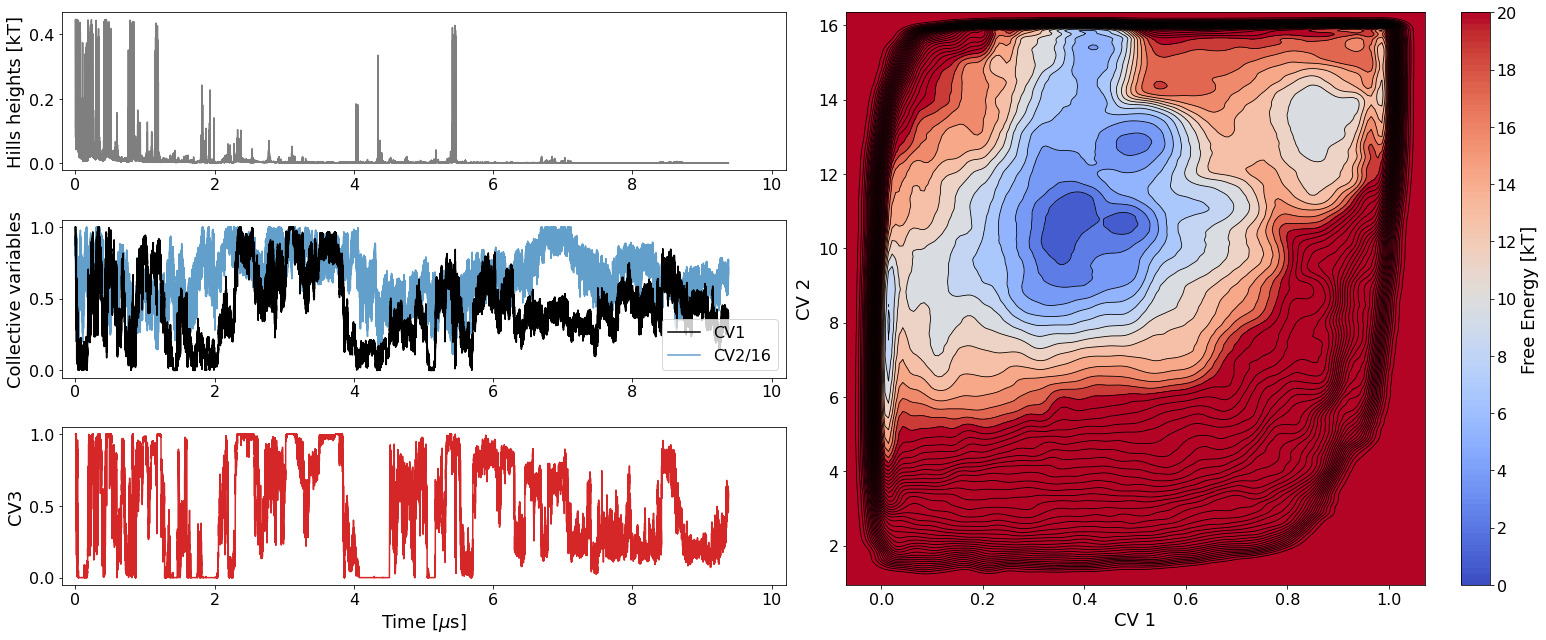

In [29]:
fig = plt.figure(figsize=(22,9))
gs  = fig.add_gridspec(nrows=3, ncols=4)

ax1 = fig.add_subplot(gs[0, 0:2])
ax1.plot( hills[:,0]/1e6, hills[:,5]/kt, c='tab:grey')
ax1.set_ylabel('Hills heights [kT]')
ax1.set_xlim((-0.2,10.2))

ax2 = fig.add_subplot(gs[1, 0:2])
ax2.plot(hills[:,0]/1e6, hills[:,1], c='k', label='CV1', zorder=1)
ax2.plot(hills[:,0]/1e6, hills[:,2]/16., c='tab:blue', label='CV2/16', alpha=0.7, zorder=0)
ax2.legend(loc=4)
ax2.set_xlim((-0.2,10.2))
ax2.set_ylabel('Collective variables')

ax3 = fig.add_subplot(gs[2, 0:2])
ax3.plot(cv3[:,0]/1e4, cv3[:,3], c='tab:red')
ax3.set_ylabel('CV3')
ax3.set_xlabel(r'Time [$\mu$s]')
ax3.set_xlim((-0.2,10.2))

ax4 = fig.add_subplot(gs[:, 2:])
vm = 20 # maximum value of free energy
x, y, z  = np.loadtxt(colvars + 'fes_cv1_cv2.dat', usecols=(0,1,2,), unpack=True)
x = np.unique(x)
y = np.unique(y)
X, Y = np.meshgrid(x, y)
Z = z.reshape(X.shape)
contour = ax4.contour(X, Y, Z/kt, 50, colors='black',  vmax=vm, linewidths=0.8)
contourf = ax4.contourf(X, Y, Z/kt, 50, cmap='coolwarm', vmax=vm)
ax4.set_xlabel('CV 1')
ax4.set_ylabel('CV 2')

# for nice colorbar
m    = cm.ScalarMappable(cmap=cm.coolwarm)
m.set_array(Z)
m.set_clim(0., vm)
cbar = plt.colorbar(m, boundaries=np.linspace(0, vm, 100), orientation='vertical', \
                    ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], ax=ax4)
cbar.ax.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, '>20'])
cbar.set_label('Free Energy [kT]')
cbar.ax.tick_params(labelsize = 16)

plt.tight_layout()
#plt.savefig(pics + 'figS3.pdf')

## PBMetaD

In [263]:
sim = 'trajectories/pbmetad/'
tp = 'topologies/'
pics = 'pics/analysis/'
plumed = 'plumed/pbmetad/'
colvars = 'colvars/pbmetad/' 
shoot = 'colvars/shootings/'
comm = 'colvars/committor/'
kt = 2.494339

In [15]:
hills  = {}
labels = ['qh', 'ab', 'qtyr', 'qtyra', 'hh'] 
for l in labels:
    hills[l] = quick_load(colvars + f'HILLS.{l}')

### Weights and Free Energy

In [264]:
#initial 1us transient has been removed
w1 = np.genfromtxt(colvars + 'WEIGHTS0_notrans') 
w2 = np.genfromtxt(colvars + 'WEIGHTS1_notrans') 
wt = np.concatenate((w1,w2))
w_exp = np.exp((wt[:,6] - np.max(wt[:,6])))
wt[:,6] = w_exp
wtt = np.copy(wt)
wt = np.delete(wt, 0, 1)
np.savetxt(colvars + "WEIGHTS", wt, fmt='%g')
w = quick_load(colvars + 'WEIGHTS')

Free energy profile along CV1 and CV2

In [54]:
h, _, _ = np.histogram2d(w[:,0], w[:,3], bins=80, weights=w[:,-1])
fes = -np.log(h)
fes -= np.min(fes)
fes = fes.T

/var/folders/nf/8f_gmpr92ddb6yz_3wnkt2pr0000gn/T/ipykernel_20659/1183828009.py:2: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(h)


Free energy profile along CV1 and CV3

In [55]:
h, _, _ = np.histogram2d(w[:,0], w[:,1], bins=50, weights=w[:,-1])
fes_cv13 = -np.log(h)
fes_cv13 -= np.min(fes_cv13)
fes_cv13 = fes_cv13.T

/var/folders/nf/8f_gmpr92ddb6yz_3wnkt2pr0000gn/T/ipykernel_20659/1382210924.py:2: RuntimeWarning: divide by zero encountered in log
  fes_cv13 = -np.log(h)


Free energy profile along CV2 and CV3

In [56]:
h, _, _ = np.histogram2d(w[:,3], w[:,1], bins=50, weights=w[:,-1])
fes_cv32 = -np.log(h)
fes_cv32 -= np.min(fes_cv32)
fes_cv32 = fes_cv32.T

/var/folders/nf/8f_gmpr92ddb6yz_3wnkt2pr0000gn/T/ipykernel_20659/2007842396.py:2: RuntimeWarning: divide by zero encountered in log
  fes_cv32 = -np.log(h)


Free energy profiles along CV4 and CV5, separately

In [57]:
h, _ = np.histogram(w[:,2], bins=50, weights=w[:,-1])
fes_cv4 = -np.log(h)
fes_cv4 -= np.min(fes_cv4)
fes_cv4 = fes_cv4.T

h, _ = np.histogram(w[:,4], bins=50, weights=w[:,-1])
fes_cv5 = -np.log(h)
fes_cv5 -= np.min(fes_cv5)
fes_cv5 = fes_cv5.T

### Y174-R332 hydrogen bond

In [21]:
w1_hbond = np.genfromtxt( colvars + 'hbond0.dat' )[::10]
w2_hbond = np.genfromtxt( colvars + 'hbond1.dat' )[::10]
hbond1 = np.array([i[0] for i in w1_hbond if i[1] == 1])
hbond2 = np.array([i[0] for i in w2_hbond if i[1] == 1])

### Compute CVs for representative strctures

In [22]:
# for i in range(1,6):
#     for j in range(10):
#         ! plumed driver --mf_pdb {sim}/conformations/s{i}_{j}.pdb --plumed plumed/md/shootings.dat
#         ! mv CV123_shootings {colvars}/conformations/CV123_s{i}_{j}

### Convergence

In [39]:
w1 = np.genfromtxt(colvars + 'WEIGHTS0_notrans') 
w2 = np.genfromtxt(colvars + 'WEIGHTS1_notrans') 
data = np.concatenate((w1,w2))
nrep = 2
temp = 300 #K
step = 1e4
stat = []
for i in range(np.shape(data)[1] - 1):
    fblock.blocker(data, multi=nrep) 
    cv, bias = fblock.check(data[:,i], data[:,-1], multi=nrep)
    s = fblock.fblocking(cv, bias, temp=temp, multi=nrep)
    stat.append(s)

Removing 1 at the bottom of each replica
Possible blocks transformations: 35

Removing 1 at the bottom of each replica
Possible blocks transformations: 35

Removing 1 at the bottom of each replica
Possible blocks transformations: 35

Removing 1 at the bottom of each replica
Possible blocks transformations: 35

Removing 1 at the bottom of each replica
Possible blocks transformations: 35

Removing 1 at the bottom of each replica
Possible blocks transformations: 35



### Bound-unbound equilibrium

In [40]:
w1 = np.genfromtxt(colvars + 'WEIGHTS0_notrans')[:-1] 
w2 = np.genfromtxt(colvars + 'WEIGHTS1_notrans')[:-1] 
data = np.concatenate((w1,w2))

Run block error analysis on the bound-unbound free energy difference for all the possible choices of bound and unbound states. 

In [41]:
unbound_state = [0,50,0,100]
bound_state = [50,100,0,100]
h, _, _ = np.histogram2d(data[:,1], data[:,4], bins=100, weights=data[:,-1])

ddGs, ddGs_err = [], []
dG_exp = np.log(1/10)
for i in np.arange(0, 50, 5):
    us = unbound_state[:]
    bs = bound_state[:]
    us[1] += i
    bs[0] += i
    
    p_bound = integrate_prob(h, bs)
    p_unbound = integrate_prob(h, us)
    dG_comp = np.log(p_unbound/p_bound)
    ddG = np.fabs(dG_exp - dG_comp)
    ddGs.append(ddG)
    deltaG_err = block_deltaG(data, bs, us, 1, 4, -1)
    ddGs_err.append(deltaG_err)

Run block error analysis on the bound-unbound populations for all the possible choices of bound and unbound states. 

In [42]:
unbound_state = [0,50,0,100]
bound_state = [50,100,0,100]
h, _, _ = np.histogram2d(data[:,1], data[:,4], bins=100, weights=data[:,-1])

pbs, pus, pb_errs, pu_errs = [], [], [], []
for i in np.arange(0, 50, 5):
    us = unbound_state[:]
    bs = bound_state[:]
    us[1] += i
    bs[0] += i
    
    p_bound = integrate_prob(h, bs)
    p_unbound = integrate_prob(h, us)
    pbs.append(p_bound)
    pus.append(p_unbound)
    
    pb_err = block_population(data, bs, 1, 4, -1)
    pu_err = block_population(data, us, 1, 4, -1)
    pb_errs.append(pb_err)
    pu_errs.append(pu_err)

Select the last block as errors because of lack of convergence

In [43]:
err = [i[-1,1] for i in ddGs_err]
pb_err = [i[-1,1] for i in pb_errs]
pu_err = [i[-1,1] for i in pu_errs]

### Paper figures

**Fig**. S4

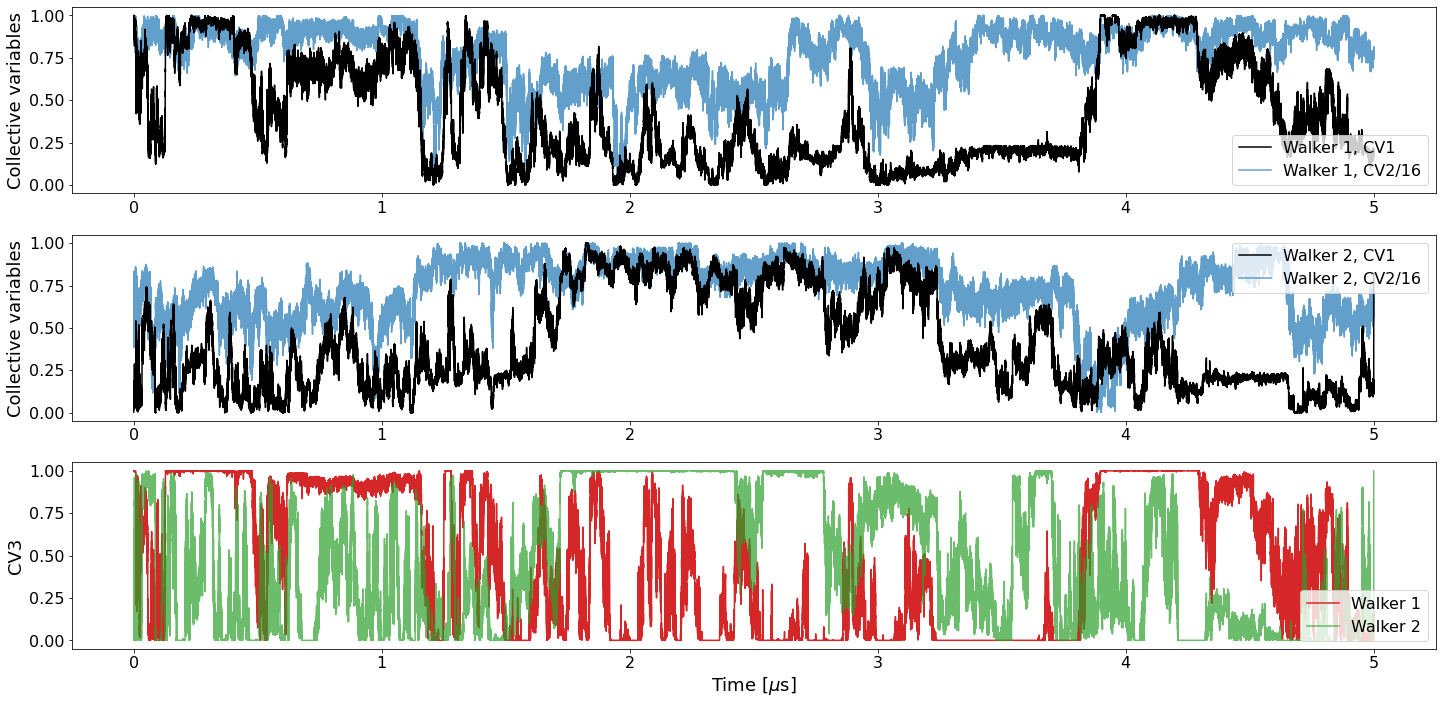

In [23]:
fig = plt.figure(figsize=(20,10))
gs  = fig.add_gridspec(nrows=3, ncols=3)

# CV1 and CV2 for walker 1
ax1 = fig.add_subplot(gs[0, :]) 
cv1 = hills['qh'][:,1][::2][::10]
cv2 = hills['ab'][:,1][::2][::10]/16
t   = np.linspace(0,5,len(cv1))

ax1.plot(t,cv1,c='k', label='Walker 1, CV1', zorder=1)
ax1.plot(t,cv2,c='tab:blue', label='Walker 1, CV2/16', alpha=0.7, zorder=0)
ax1.legend(loc=4)
ax1.set_ylabel('Collective variables')

# CV1 and CV2 for walker 2
ax2 = fig.add_subplot(gs[1, :])
cv1 = hills['qh'][:,1][1:][::2][::10]
cv2 = hills['ab'][:,1][1:][::2][::10]/16

ax2.plot(t,cv1,c='k', label='Walker 2, CV1', zorder=1)
ax2.plot(t,cv2,c='tab:blue', label='Walker 2, CV2/16', alpha=0.7, zorder=0)
ax2.legend(loc=1)
ax2.set_ylabel('Collective variables')

# CV3 for walkers 1 and 2
ax3  = fig.add_subplot(gs[2, :])
cv31 = hills['qtyr'][:,1][::2][::10]
cv32 = hills['qtyr'][:,1][1:][::2][::10]

ax3.plot(t, cv31, c='tab:red', label='Walker 1')
ax3.plot(t, cv32, c='tab:green', label='Walker 2', alpha=0.7)
ax3.legend(loc=4)
ax3.set_ylabel('CV3')
ax3.set_xlabel(r'Time [$\mu$s]')

plt.tight_layout()
#plt.savefig(pics + 'figS4.pdf')

**Fig.** 2A

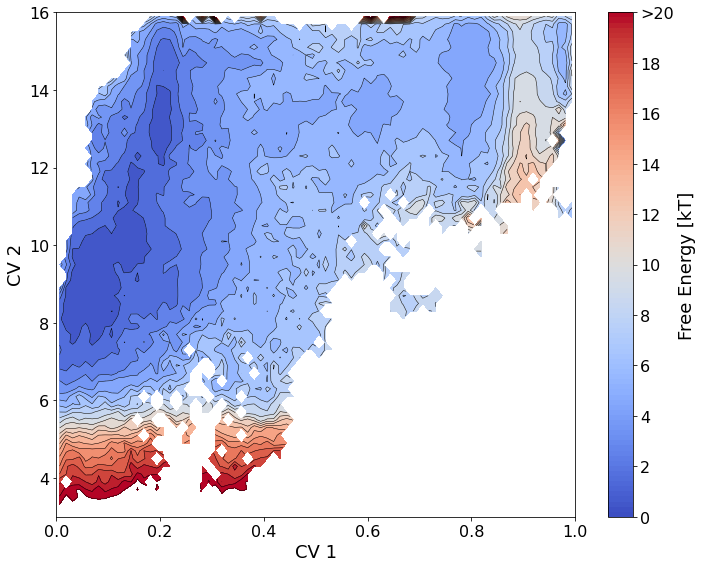

In [58]:
fig = plt.figure(figsize = (10,8))

# free energy
vm       = 20 
contourf = plt.contourf(fes, levels = range(vm+2), cmap = 'coolwarm', 
                        zorder = -1, vmax = vm, extent = (0,1,0,16), origin = 'lower' )
contour = plt.contour(fes, levels = range(vm+2), colors = 'black', 
                     vmax = vm, linewidths = 0.5, extent = (0,1,0,16), origin = 'lower' )
plt.xlabel('CV 1')
plt.ylabel('CV 2')
plt.ylim((3,16))
plt.xlim((0,1))

m = cm.ScalarMappable(cmap = cm.coolwarm)
m.set_clim(0., vm)
cbar = plt.colorbar(m, boundaries = np.linspace(0, vm, 100), \
                    ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] )
cbar.ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, '>20'])
cbar.set_label('Free Energy [kT]')
cbar.ax.tick_params(labelsize = 16)

plt.tight_layout()
#plt.savefig(pics + 'fig2A.pdf')

**Fig.** 3

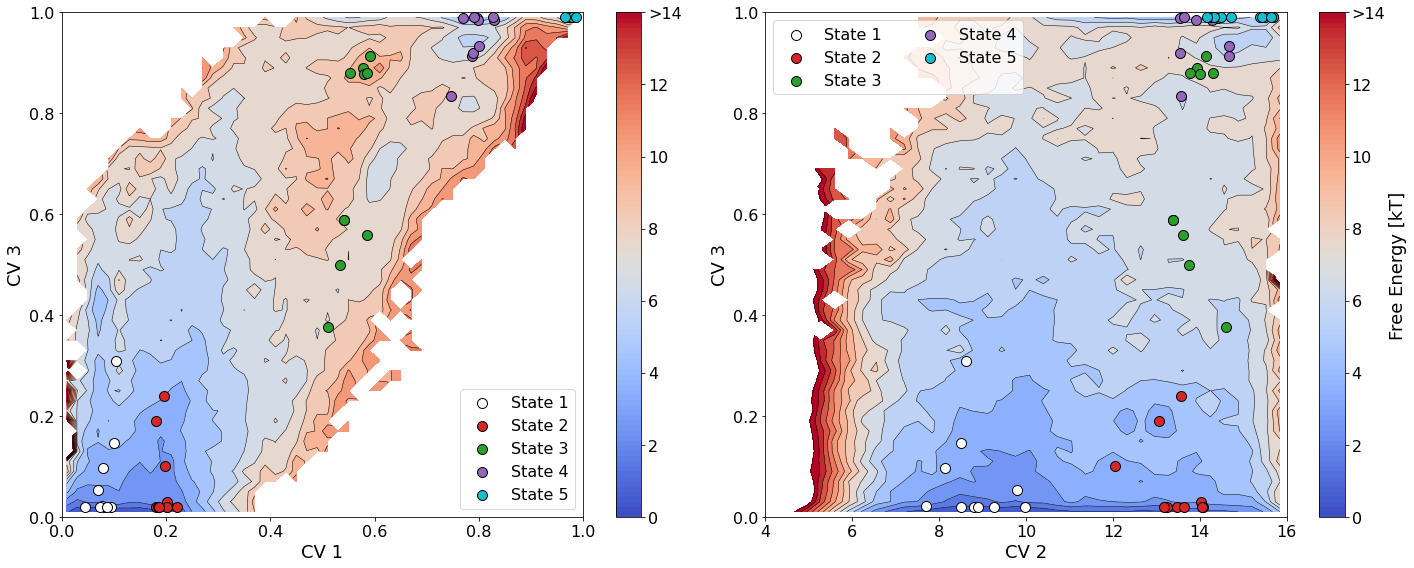

In [25]:
fig = plt.figure(figsize = (20,8))
vm = 14
plt.subplot(1,2,1)

# free energy
contourf = plt.contourf(fes_cv13, levels = range(vm+2), cmap = 'coolwarm', 
                        zorder = -1, vmax = vm, extent = (0,1,0,1), origin = 'lower' )
contour = plt.contour(fes_cv13, levels = range(vm+2), colors = 'black', 
                     vmax = vm, linewidths = 0.5, extent = (0,1,0,1), origin = 'lower' )

colors = [ 'w', 'tab:red', 'tab:green', 'tab:purple', 'tab:cyan' ]
for i in range(1,6):
    for j in range(10):
        cv = np.loadtxt(colvars + f'conformations/CV123_s{i}_{j}')
        if i == 1 or i == 2:
            b = 0.02
        else:
            b = -0.01
        if j == 0:
            plt.scatter( cv[1], cv[3]+b, c = colors[i-1], edgecolor = 'k', s = 100, zorder = 20, label = f'State {i}')
        else:
            plt.scatter( cv[1], cv[3]+b, c = colors[i-1], edgecolor = 'k', s = 100, zorder = 20 )
plt.legend( loc = 4 )

plt.xlabel('CV 1')
plt.ylabel('CV 3')
plt.ylim((0,1))
plt.xlim((0,1))

m = cm.ScalarMappable(cmap = cm.coolwarm)
m.set_clim(0., vm)
cbar = plt.colorbar(m, boundaries = np.linspace(0, vm, 100), \
                    ticks = [0, 2, 4, 6, 8, 10, 12, 14] )
cbar.ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12, '>14'])
cbar.ax.tick_params(labelsize = 16)

plt.subplot(1,2,2)
# free energy
contourf = plt.contourf(fes_cv32, levels = range(vm+2), cmap = 'coolwarm', 
                        zorder = -1, vmax = vm, extent = (0,16,0,1), origin = 'lower' )
contour = plt.contour(fes_cv32, levels = range(vm+2), colors = 'black', 
                     vmax = vm, linewidths = 0.5, extent = (0,16,0,1), origin = 'lower' )

colors = [ 'w', 'tab:red', 'tab:green', 'tab:purple', 'tab:cyan' ]
for i in range(1,6):
    for j in range(10):
        cv = np.loadtxt( colvars + f'conformations/CV123_s{i}_{j}')
        if i == 1 or i == 2:
            b = 0.02
        else:
            b = -0.01
        if j == 0:
            plt.scatter( cv[2], cv[3]+b, c = colors[i-1], edgecolor = 'k', s = 100, zorder = 20, label = f'State {i}')
        else:
            plt.scatter( cv[2], cv[3]+b, c = colors[i-1], edgecolor = 'k', s = 100, zorder = 20 )
plt.legend( loc = 2, ncol=2 )

plt.xlabel('CV 2')
plt.ylabel('CV 3')
plt.ylim((0,1))
plt.xlim((4,16))

m = cm.ScalarMappable(cmap = cm.coolwarm)
m.set_clim(0., vm)
cbar = plt.colorbar(m, boundaries = np.linspace(0, vm, 100), \
                    ticks = [0, 2, 4, 6, 8, 10, 12, 14] )
cbar.ax.set_yticklabels([0, 2, 4, 6, 8, 10, 12, '>14'])
cbar.set_label('Free Energy [kT]')
cbar.ax.tick_params(labelsize = 16)
plt.tight_layout()
#plt.savefig(pics + 'fig3.pdf')

**Fig**. S5

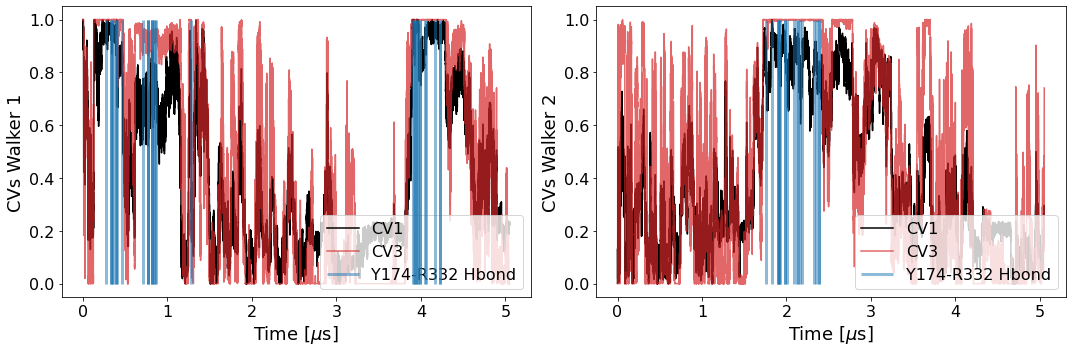

In [26]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
data = np.loadtxt(colvars + 'WEIGHTS0')
for i in hbond1:
    plt.vlines(i/1e4, 0, 1, alpha=0.5, zorder=10, color='tab:blue', linewidth=3)
plt.vlines(i/1e4, 0, 1, alpha = 0.5, zorder=10, color='tab:blue', linewidth=3, label='Y174-R332 Hbond')
plt.plot(data[:,0]/1e4, data[:,1], zorder=0, c='k', label='CV1' )
plt.plot(data[:,0]/1e4, data[:,2], zorder=0, c='tab:red', alpha=0.7, label='CV3')
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('CVs Walker 1')
plt.legend(loc=4)

data = np.loadtxt(colvars + 'WEIGHTS1')
plt.subplot(1,2,2)
for i in hbond2:
    plt.vlines( i/1e4, 0, 1, alpha=0.5, zorder=10, color='tab:blue', linewidth=3)
plt.plot(data[:,0]/1e4, data[:,1], zorder=0, c='k', label='CV1')
plt.plot(data[:,0]/1e4, data[:,2], zorder=0, c='tab:red', alpha=0.7, label='CV3')
plt.vlines( i/1e4, 0, 1, alpha=0.5, zorder=10, color='tab:blue', linewidth=3, label='Y174-R332 Hbond')
plt.xlabel(r'Time [$\mu$s]')
plt.ylabel('CVs Walker 2')
plt.legend(loc=4)

plt.tight_layout()
#plt.savefig(pics + 'figS5.pdf')

**Fig**. S6

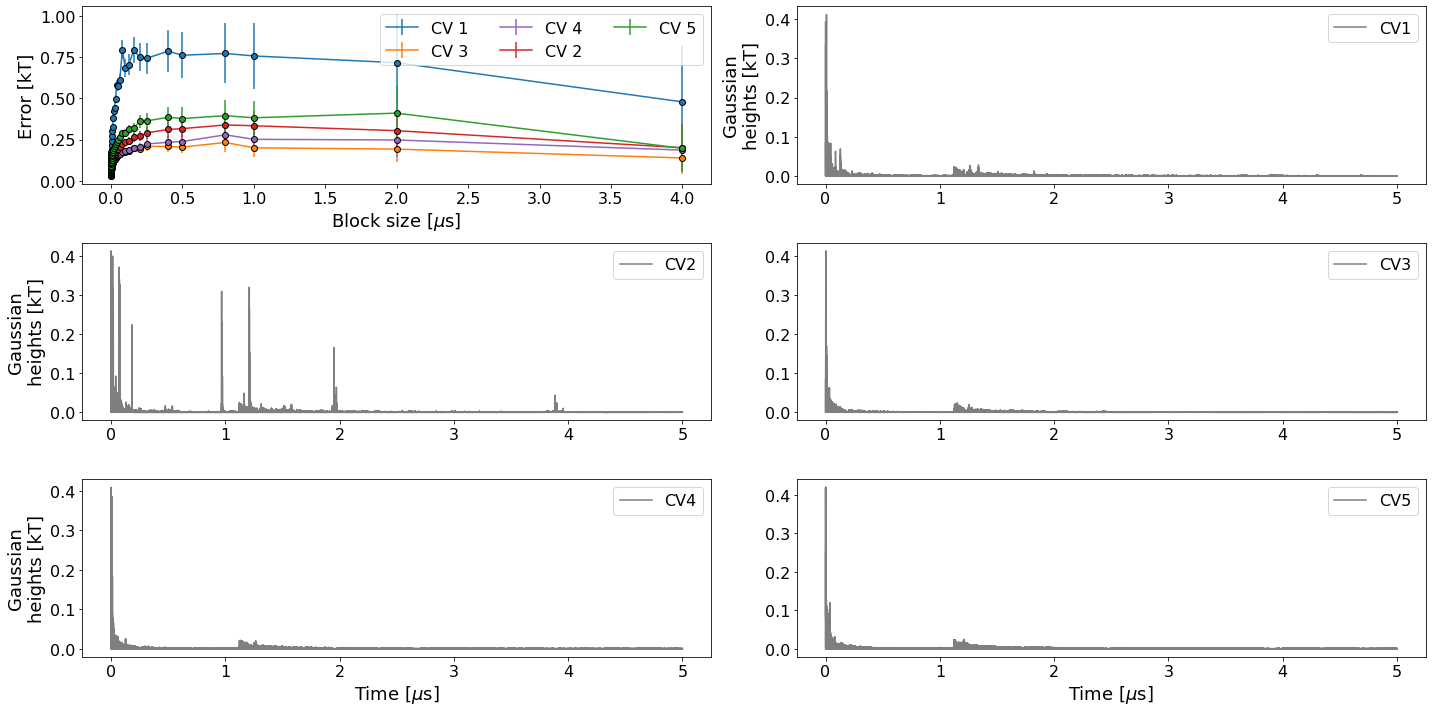

In [48]:
fig = plt.figure(figsize=(20,10))
gs  = fig.add_gridspec(nrows=3, ncols=4)

ax = fig.add_subplot(gs[0, 2:])
ax.plot(hills['hh'][:,0]/1e6, hills['qh'][:,3]/kt, color='tab:grey', label=f'CV1')
ax.set_ylabel('Gaussian\nheights [kT]')
ax.legend(loc=1)

ax3 = fig.add_subplot(gs[0, 0:2])
c = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'tab:green']
for i in [0,2,3,1,4]:
    ax3.scatter(stat[i][:,0] / step, stat[i][:,1]/kt, c=c[i], edgecolors='k', zorder=10)
    ax3.errorbar(stat[i][:,0] / 1e4, stat[i][:,1]/kt, yerr=stat[i][:,2]/kt, c=c[i], label=f'CV {i+1}', 
                 zorder=0)
ax3.set_ylabel('Error [kT]')
ax3.set_xlabel(r'Block size [$\mu$s]')
ax3.legend(ncol=3, loc=1)

for n, (i,j) in enumerate(prange(['ab', 'qtyr', 'qtyra', 'hh'])):
    if n == 0:
        lbl = [2,3]
    else:
        lbl = [4,5]
    
    ax1 = fig.add_subplot(gs[n+1, 0:2])
    ax1.plot( hills[i][:,0]/1e6, hills[i][:,3]/kt, color='tab:grey', label=f'CV{lbl[0]}')
    ax1.set_ylabel('Gaussian\nheights [kT]')
    ax1.legend(loc=1)
    
    ax2 = fig.add_subplot(gs[n+1, 2:])
    ax2.plot(hills[j][:,0]/1e6, hills[j][:,3]/kt, color='tab:grey', label=f'CV{lbl[1]}')
    ax2.legend(loc=1)
    
    if n == 1:
        ax1.set_xlabel(r'Time [$\mu$s]')
        ax2.set_xlabel(r'Time [$\mu$s]')
    
plt.tight_layout()
#plt.savefig(pics+"figS6.png")

**Fig**. S7

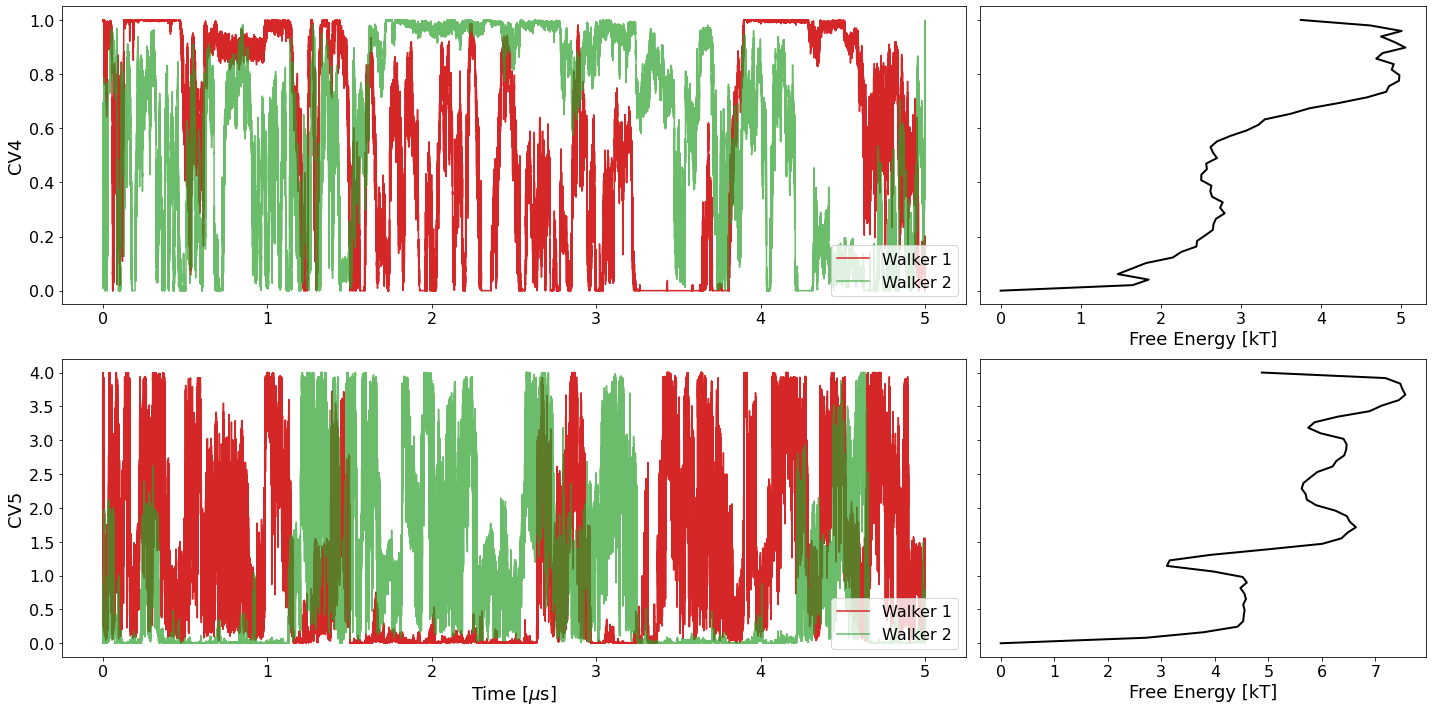

In [49]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(nrows=2, ncols=3)

# CV4 for walkers 1 and 2
ax1  = fig.add_subplot(gs[0, :2])
cv41 = hills['qtyra'][:,1][::2][::10]
cv42 = hills['qtyra'][:,1][1:][::2][::10]
t = np.linspace(0,5,len(cv41))

ax1.plot(t, cv41, c='tab:red', label='Walker 1')
ax1.plot(t, cv42, c='tab:green', label='Walker 2', alpha=0.7)
ax1.legend(loc=4)
ax1.set_ylabel('CV4')

ax2 = fig.add_subplot(gs[0,2])
x = np.linspace(0, 1, len(fes_cv4))
ax2.plot(fes_cv4, x, c='k', lw=2)
ax2.set_xlabel('Free Energy [kT]')
ax2.yaxis.set_major_formatter(plt.NullFormatter())

# CV5 walkers 1 and 2
ax3  = fig.add_subplot(gs[1, :2])
cv51 = hills['hh'][:,1][::2][::10]
cv52 = hills['hh'][:,1][1:][::2][::10]
t = np.linspace(0,5,len(cv51))

ax3.plot(t, cv51, c='tab:red', label='Walker 1')
ax3.plot(t, cv52, c='tab:green', label='Walker 2', alpha=0.7)
ax3.legend(loc=4)
ax3.set_ylabel('CV5')
ax3.set_xlabel(r'Time [$\mu$s]')

ax4 = fig.add_subplot(gs[1,2])
x = np.linspace(0, 4, len(fes_cv5))
ax4.plot(fes_cv5, x, c='k', lw=2)
ax4.set_xlabel('Free Energy [kT]')
ax4.yaxis.set_major_formatter(plt.NullFormatter())

plt.tight_layout()
#plt.savefig(pics + 'figS7.pdf')

**Fig**. S8A

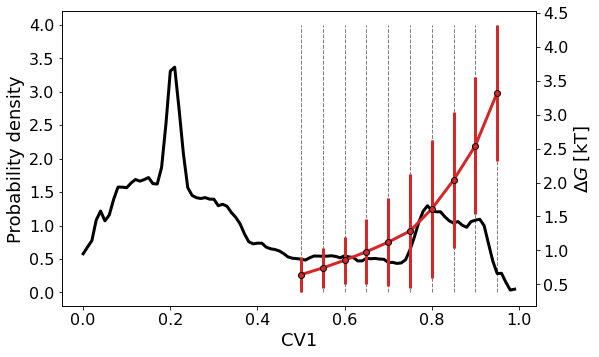

In [50]:
fig, ax1 = plt.subplots(figsize=(8,5))
x = np.arange(data[:,1].min(), data[:,1].max(), 0.01)
kde = gaussian_kde(data[:,1], weights=data[:,-1])
kde.set_bandwidth(bw_method=kde.factor / 5.)
p = kde(x)
lns1 = ax1.plot(x, p, c='k', lw=3, label='Probability density')
lns2 = ax1.vlines(0.5, 0, 4, ls='--', color='tab:grey', lw=1, label='Unbound state cutoff')
for i in np.arange(0.55, 1, 0.05):
    ax1.vlines(i, 0, 4, ls='--', color='tab:grey', lw=1)
ax1.set_ylabel('Probability density')
ax1.set_xlabel('CV1')

ax2 = ax1.twinx()
x = np.arange(0.5, 1., 0.05) 
lns3 = ax2.errorbar(x, [i-2.3 for i in ddGs], yerr=err, c='tab:red', fmt='o-', markeredgecolor='k', lw=3, 
                    label=r'$\Delta \Delta G$')
ax2.set_ylabel(r'$\Delta G$ [kT]')
lns = lns1+[lns2]+[lns3]
labs = [l.get_label() for l in lns]
plt.tight_layout()
#plt.savefig(pics + 'figS8A.pdf')

**Fig**. S8B

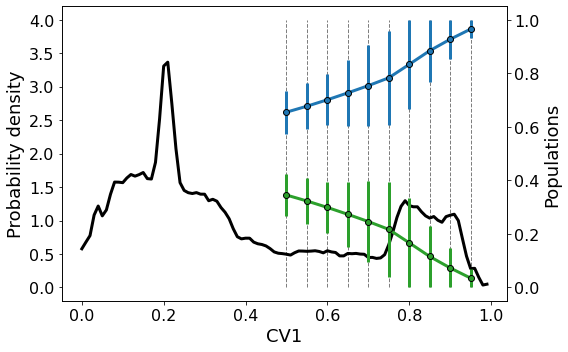

In [51]:
fig, ax1 = plt.subplots(figsize=(8,5))
x = np.arange(data[:,1].min(), data[:,1].max(), 0.01)
kde = gaussian_kde(data[:,1], weights=data[:,-1])
kde.set_bandwidth(bw_method=kde.factor / 5.)
p = kde(x)
lns1 = ax1.plot(x, p, c='k', lw=3, label='Free energy')
lns2 = ax1.vlines(0.5, 0, 4, ls='--', color='tab:grey', lw=1, label='Unbound state cutoff')
for i in np.arange(0.55, 1, 0.05):
    ax1.vlines(i, 0, 4, ls='--', color='tab:grey', lw=1)
ax1.set_ylabel('Probability density')
ax1.set_xlabel('CV1')
#ax1.legend(loc=3)

ax2 = ax1.twinx()
x = np.arange(0.5, 1., 0.05) 
lns3 = ax2.errorbar(x, pbs, yerr=pb_err, c='tab:green', fmt='o-', markeredgecolor='k', lw=3, label='Bound')
lns4 = ax2.errorbar(x, pus, yerr=pu_err, c='tab:blue', fmt='o-', markeredgecolor='k', lw=3, label='Unbound')
ax2.set_ylabel('Populations')
plt.tight_layout()
lns = [lns3]+[lns4]
labs = [l.get_label() for l in lns]
plt.tight_layout()
#plt.savefig(pics + 'figS8B.pdf')

**Fig**. S9A

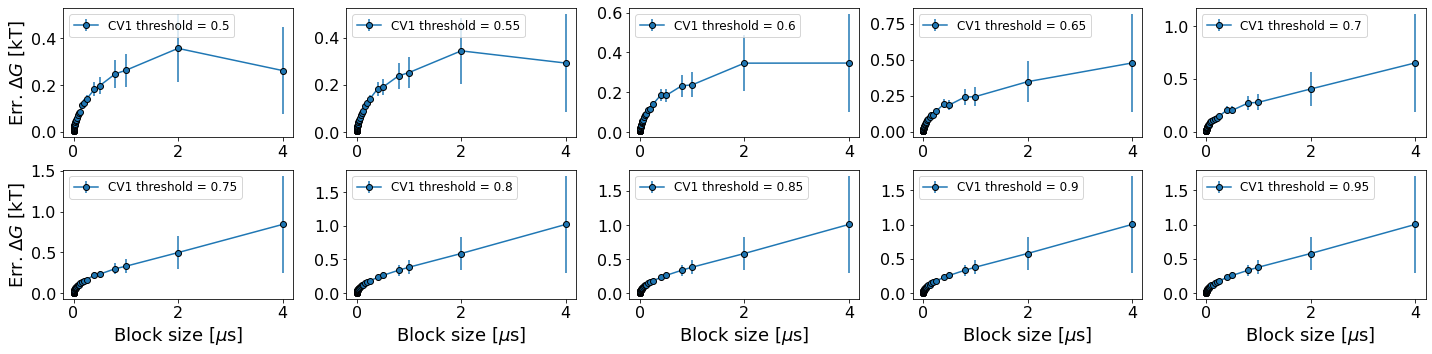

In [52]:
plt.figure(figsize=(20,5))
for j,i in enumerate(np.arange(0, 50, 5)):
    plt.subplot(2,5,j+1)
    ii = (50 + i)/100
    plt.errorbar(ddGs_err[j][:,0]/1e4, ddGs_err[j][:,1], yerr=ddGs_err[j][:,2], c='tab:blue', zorder=0, fmt='o-', 
                markeredgecolor='k', label=f'CV1 threshold = {ii}')
    if j == 0 or j == 5:
        plt.ylabel(r'Err. $\Delta G$ [kT]')
    if j > 4:
        plt.xlabel(r'Block size [$\mu$s]')
    plt.legend(fontsize=12, loc=2)
plt.tight_layout()
#plt.savefig(pics + 'figS9A.pdf')

**Fig**. S9B

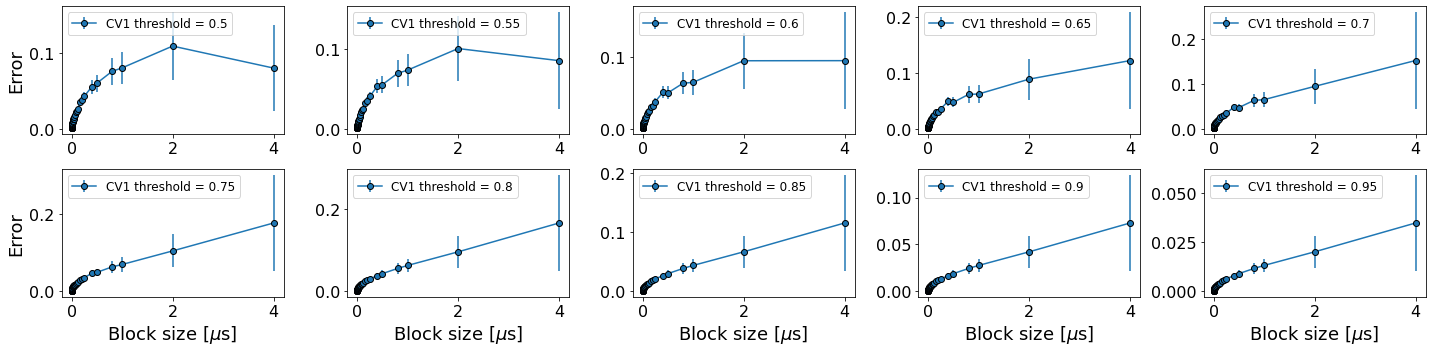

In [53]:
plt.figure(figsize=(20,5))
for j,i in enumerate(np.arange(0, 50, 5)):
    plt.subplot(2,5,j+1)
    ii = (50 + i)/100
    plt.errorbar(pb_errs[j][:,0]/1e4, pb_errs[j][:,1], yerr=pb_errs[j][:,2], c='tab:blue', zorder=0, fmt='o-', 
                markeredgecolor='k', label=f'CV1 threshold = {ii}')
    if j == 0 or j == 5:
        plt.ylabel('Error')
    if j > 4:
        plt.xlabel(r'Block size [$\mu$s]')
    plt.legend(fontsize=12, loc=2)
plt.tight_layout()
#plt.savefig(pics + 'figS9B.pdf')

**Fig**. S9C

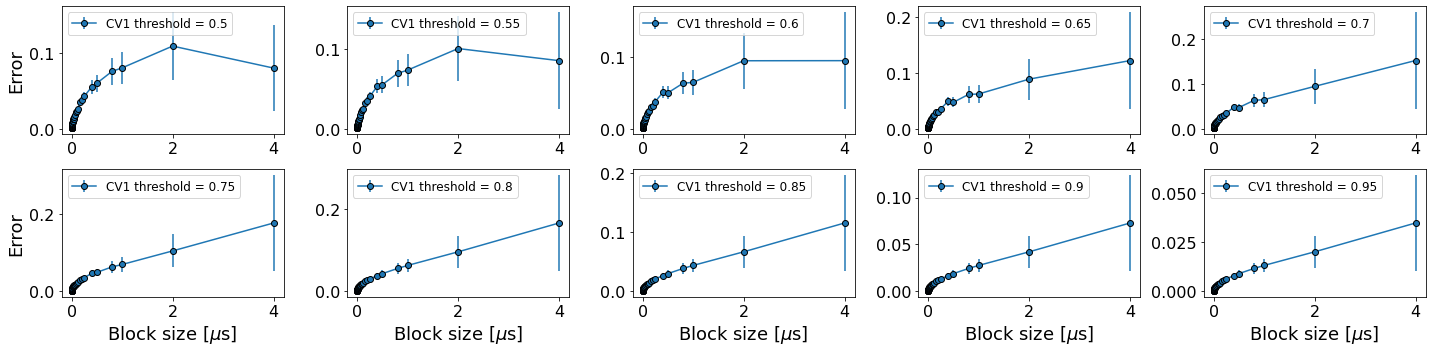

In [54]:
plt.figure(figsize=(20,5))
for j,i in enumerate(np.arange(0, 50, 5)):
    plt.subplot(2,5,j+1)
    ii = (50 + i)/100
    plt.errorbar(pu_errs[j][:,0]/1e4, pu_errs[j][:,1], yerr=pu_errs[j][:,2], c='tab:blue', zorder=0, fmt='o-', 
                markeredgecolor='k', label=f'CV1 threshold = {ii}')
    if j == 0 or j == 5:
        plt.ylabel('Error')
    if j > 4:
        plt.xlabel(r'Block size [$\mu$s]')
    plt.legend(fontsize=12, loc=2)
plt.tight_layout()
#plt.savefig(pics + 'figS9C.pdf')

## Unbiased MD simulations

### Transition state

Prepare Plumed file for Metad CVs

In [27]:
helix_c = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
helix = [1, 2, 3, 4, 5, 6, 7, 8]
discardj = []
r1 = [6]
r2 = [37, 41, 160, 163, 164]
plumedf = os.path.abspath( 'plumed/md/shootings.dat' ) 
cvfile = os.path.abspath( 'CV123_shootings' )
fprotein = os.path.abspath( 'topologies/cry_disp.pdb' ) 
ref = md.load( 'topologies/cry_disp.pdb' )
top = ref.topology
group1 = top.select( selection_string(r1) )
group2 = top.select( selection_string(r2) )
_ = cvs_for_plumed( ref, discardj, helix, helix_c, group1, group2, fprotein, plumedf, cvfile )

In [28]:
# for i in range(1,6):
#     for j in range(1,6):
#         ! plumed driver --mf_xtc trajectories/committor/s{i}_run{j}.xtc --plumed plumed/md/shootings.dat 
#         ! mv CV123_shootings colvars/committor2/s{i}_run{j}

In [29]:
fold = 0
fold_cutoff = 0.98
unfo_cutoff = 0.82
buffer = 3
times_f = []
times_u = []
times = []
foldings = []

for i in range(1,6):
    f = 0
    for j in range(1,6):
        path = np.loadtxt(f'colvars/committor/s{i}_run{j}')
        for n,p in enumerate(path):
            if p[1] < unfo_cutoff:
                break
            elif p[1] > fold_cutoff:
                fold += 1
                f += 1
                times_f.append( p[0]/10.)
                times.append(p[0]/10.)
                break
    foldings.append(f)

for i in range(1,6):
    for j in range(1,6):
        path = np.loadtxt(f'colvars/committor/s{i}_run{j}')
        for n,p in enumerate(path):
            if p[1] > fold_cutoff:
                break
            elif p[1] < unfo_cutoff:
                times_u.append(p[0]/10.)
                times.append(p[0] / 10.)
                break

tau_tp  = np.average(times_f) + np.average(times_u)
tau_er  = np.sqrt(np.std(times_f)**2 + np.std(times_u)**2)
tau_er /= np.sqrt(len(times_f) + len(times_u))
print(f"<tau_TP> = {tau_tp:.3} +/- {tau_er:.3}ns")

fp = [f/5 for f in foldings]
avgs = []
for i in range(1,5):
    fp_tmp = np.concatenate((fp[:i], fp[i+1:]))
    avgs.append( np.average(fp_tmp) )    
print(f"q: {np.average(avgs):.3f} +/- {np.std(avgs)/np.sqrt(4):.3f}")

bdG = 3.5
tau_MFP = 2. * np.pi * tau_tp / np.log(3. * bdG) * np.exp(bdG) / 1e3
err_MFP = 2. * np.pi * tau_er / np.log(3. * bdG) * np.exp(bdG) / 1e3

print(f"Mean first passage time: {tau_MFP:.3} +/- {err_MFP:.3}")

<tau_TP> = 50.0 +/- 13.3ns
q: 0.475 +/- 0.052
Mean first passage time: 4.43 +/- 1.18


### Shootings

Compute MetaD CVs from unbiased MD trajectories

In [30]:
# traj_list = glob.glob("trajectories/shootings/vav1*.xtc")
# for i in range(1,len(traj_list)+1):
#     ! plumed driver --mf_xtc trajectories/shootings/vav1_{i}.xtc --plumed plumed/md/shootings.dat 
#     ! mv CV123_shootings colvars/shootings/CV123_{i}

### Paper figures

In [68]:
bound = range(1,8)
molten = range(8,14)
unbound = range(14,24)
to_unbound = range(24,31)
to_bound = [34]#range(31,35)
to_molten = range(35,44)
shoots = [bound, molten, unbound, to_unbound, to_bound, to_molten]

**Fig**. 4

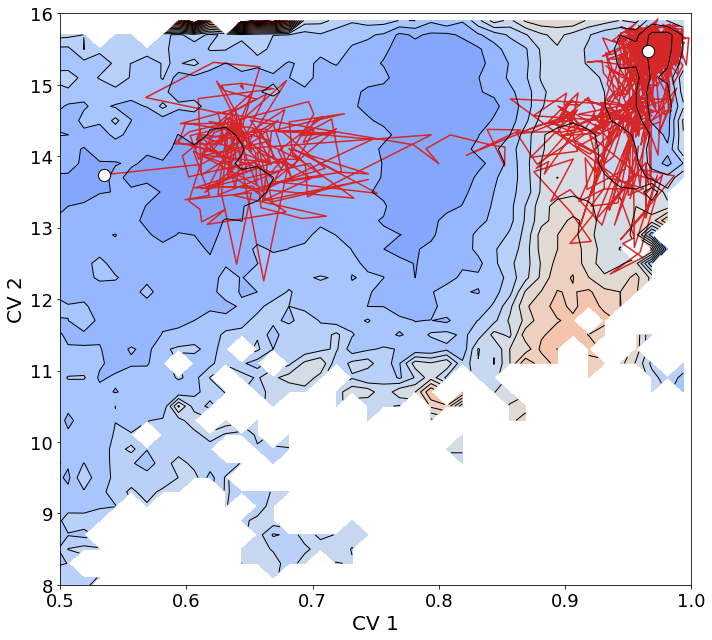

In [94]:
fig = plt.figure(figsize = (10,9))
vm = 20
p = np.loadtxt(shoot + f'CV123_34')
contourf = plt.contourf(fes, levels=range(vm+2), cmap='coolwarm', 
                        zorder=-1, vmax=vm, extent=(0,1,0,16), origin='lower')
contour = plt.contour(fes, levels=range(vm+2), colors='black', 
                     vmax=vm, linewidths=1, extent=(0,1,0,16), origin='lower', zorder=10)
plt.plot(p[:,1][::5], p[:,2][::5], color='tab:red', zorder=1)
plt.scatter(p[0,1], p[0,2], zorder=11, edgecolor='k', s=150, color='w')
plt.scatter(p[-1,1], p[-1,2], zorder=11, edgecolor='k', s=150, color='w')
plt.xlabel('CV 1', fontsize=20)
plt.ylabel('CV 2', fontsize=20)
plt.ylim((8,16))
plt.xlim((0.5,1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('unbiased_binding.pdf')

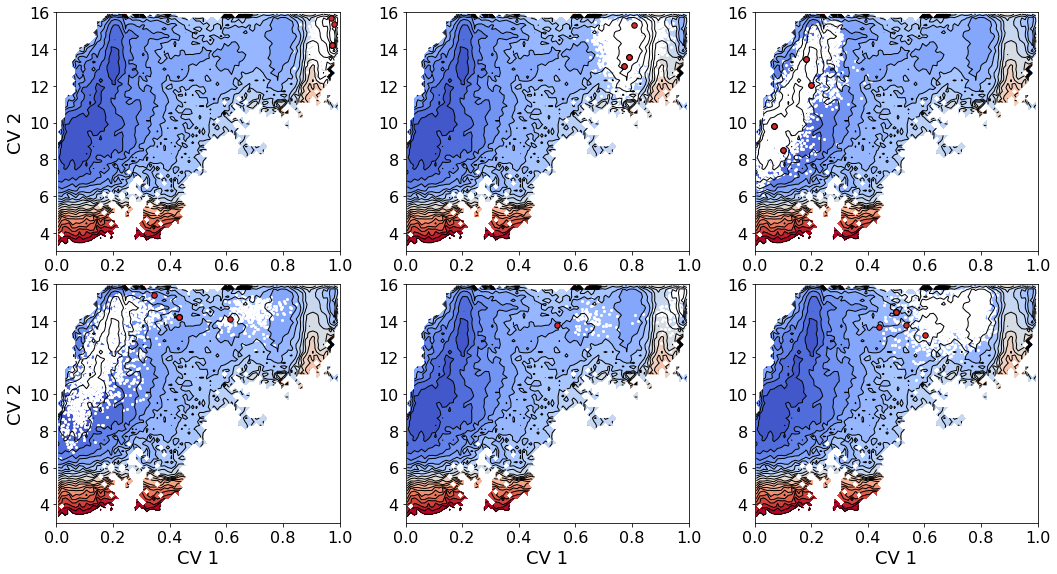

In [69]:
fig = plt.figure(figsize = (15,8))
vm = 20 
for i in range(6):
    plt.subplot(2,3,i+1)
    contourf = plt.contourf(fes, levels=range(vm+2), cmap='coolwarm', 
                            zorder=-1, vmax=vm, extent=(0,1,0,16), origin='lower')
    contour = plt.contour(fes, levels=range(vm+2), colors='black', 
                         vmax=vm, linewidths=1, extent=(0,1,0,16), origin='lower', zorder=10)
    if i > 2:
        plt.xlabel('CV 1')
    if i%3 == 0:
        plt.ylabel('CV 2')
        
    plt.ylim((3,16))
    plt.xlim((0,1))

    p = []
    for g in shoots[i]:
        p = np.loadtxt(shoot + f'CV123_{g}')
        plt.scatter(p[:,1][::stride], p[:,2][::stride], color='w', zorder=1, s=4)
        plt.scatter(p[0,1], p[0,2], zorder=11, edgecolor='k', s=30, color='tab:red')
        
plt.tight_layout()
plt.savefig(pics+'fig5.pdf', format = 'pdf')

## Markov State Model

### Featurization

Use relevant C$_\alpha$ and C$_\beta$ in the protein and compute the inverse distances among those in the Ac-helix and the ones in the binding site. 

In [15]:
struct = md.load('topologies/cry_disp.pdb')
trajs = glob.glob('trajectories/shootings/vav1_*.xtc')

In [16]:
CaCb  = np.array([4, 6, 19, 26, 28, 38, 40, 53, 55, 72, 74, 93, 95, 108, 110, 120, 122, 139, 141, 515, 517, 566,
                   568, 583, 585, 627, 629, 649, 651, 696, 698, 2454, 2456, 2478, 2480, 2531, 2533, 2555, 2557,
                   2567, 2569, 2605,2607, 2622, 2624, 2643, 2646, 2669, 2671, 2686, 2688, 2745, 2747, 2824, 2826])
helix = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
pairs = get_pairs(CaCb, struct, helix)
print(f"Number of pairs: {len(pairs)}")

Number of pairs: 19


In [17]:
feat = pyemma.coordinates.featurizer(struct)
feat.add_inverse_distances(pairs, periodic=False) #simulations are already aligned and pbcs have been removed
data = pyemma.coordinates.load(trajs, features=feat)
print(f"Total number of features: {feat.dimension()}") 

Obtaining file info:   0%|                                                                                    …

getting output of FeatureReader:   0%|                                                                        …

Total number of features: 19


### Lag-time selection using VAMP-score

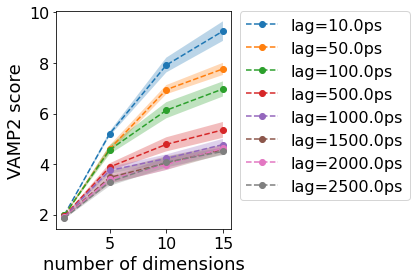

In [31]:
lags = [10, 50, 100, 500, 1000, 1500, 2000, 2500] #ps
dims = [ 1, 5, 10, 15 ]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(data, dim, lag) for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.0f}ps'.format(lag))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

### tICA dimensionality reduction

In [18]:
tica = pyemma.coordinates.tica(data, lag=500)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
print(f"Number of tICA dimensions: {tica.dimension()}")

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

Number of tICA dimensions: 10


<Figure size 1080x576 with 0 Axes>

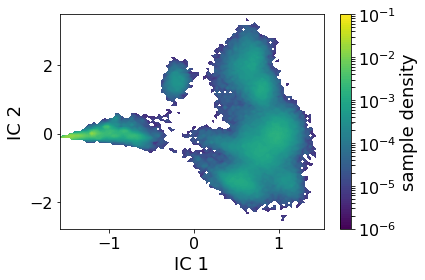

In [19]:
plt.figure(figsize=(15, 8))
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, logscale=True);
plt.xlabel('IC 1')
plt.ylabel('IC 2')
plt.tight_layout()
plt.show()

### Clustering

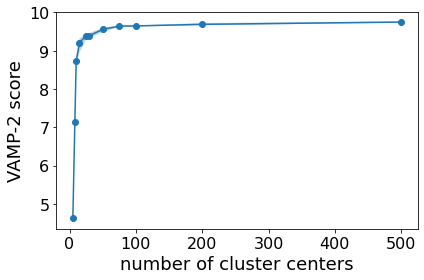

In [38]:
#I suppose we make a number of different markov models here and check the number of clusters.
n_clustercenters = [5, 8, 10, 15, 25, 30, 50, 75, 100, 200, 500]
scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [20]:
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=120, max_iter=50)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

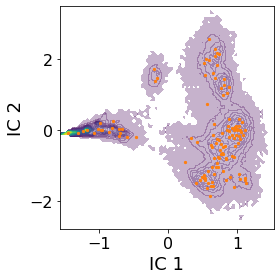

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

### MSM estimation

In [22]:
its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors='bayes')

estimating BayesianMSM:   0%|                                                                                 …

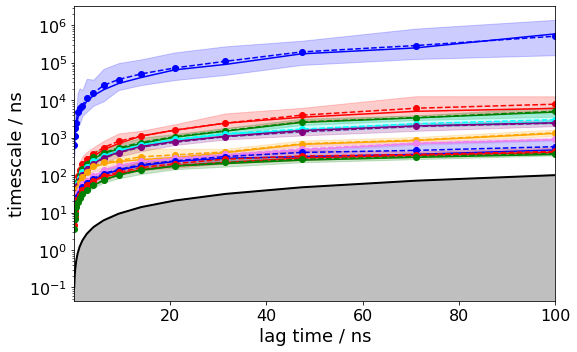

In [24]:
plt.figure(figsize=(8,5))
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1)
plt.tight_layout();

In [25]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=600, dt_traj='0.1 ns')
print(f'fraction of states used = {msm.active_state_fraction}')
print(f'fraction of counts used = {msm.active_count_fraction}')

pyemma.msm.estimators.bayesian_msm.BayesianMSM[9]: compute stat. inefficiencies:   0%|                        …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[9]: Sampling MSMs:   0%|                                       …

fraction of states used = 1.0
fraction of counts used = 1.0


### Analysis

In [46]:
nstates = 2 #given the number of deep minima in the sample density, a 3 state model seems appropriate
cktest = msm.cktest(nstates, mlags=5)

estimating BayesianMSM:   0%|                                                                                 …

/Users/simone/anaconda3/envs/pyemma/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 119 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


<Figure size 720x360 with 0 Axes>

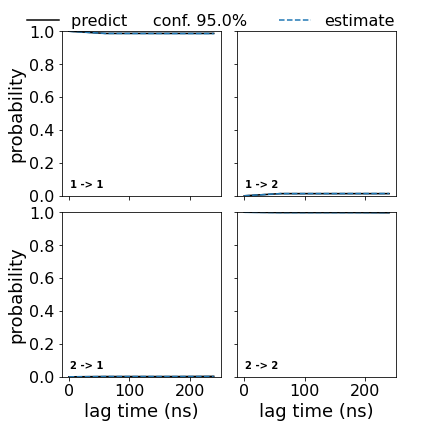

In [38]:
plt.figure(figsize=(10,5))
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

<Figure size 720x576 with 0 Axes>

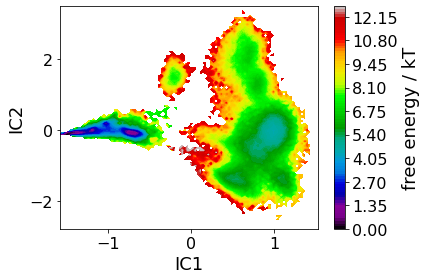

In [34]:
plt.figure(figsize=(10,8))
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    legacy=False)
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout();

<Figure size 720x576 with 0 Axes>

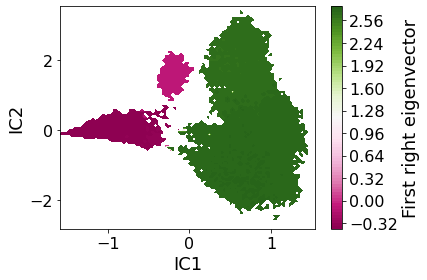

In [45]:
eigvec = msm.eigenvectors_right()
plt.figure(figsize=(10,8))
pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, 1],
        cmap='PiYG',
        cbar_label='First right eigenvector',
        mask=True)
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout();

### PCCA

In [47]:
msm.pcca(2)

PCCA(P=array([[0.10117, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.04425, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.19474, 0.00057],
       [0.     , 0.     , ..., 0.0005 , 0.06522]]),
   m=2)

Metastable distributions

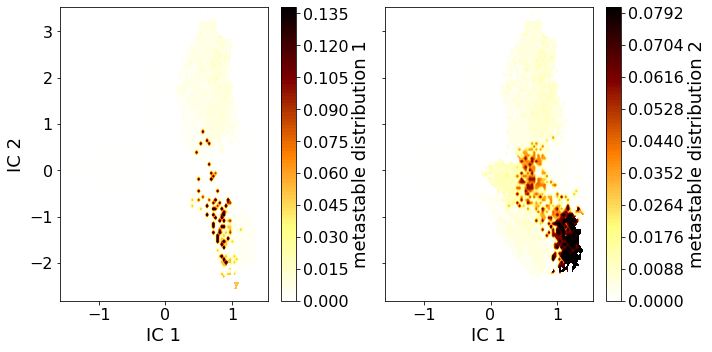

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

Extract representative ensemble from metastable states

In [49]:
# pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
# source = pyemma.coordinates.source(trajs, features=feat)
# pyemma.coordinates.save_trajs(
#     source,
#     pcca_samples,
#     outfiles=['pcca{}_new.pdb'.format(n + 1) for n in range(msm.n_metastable)])